## Objective

After looking at my handy map, I see outliers per cap bc the pop is low. I know the Census tries to get its Census blocks to be of about the same pop. Is there a clean cutoff to throw out the low-pop block groups? Would there be any useful signal in each of them?

In [1]:
from __future__ import division
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
import json
import plotly.plotly as py
import cufflinks as cf

warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set_style("whitegrid")
sns.set_context("poster")
rcParams['figure.figsize'] = 20,5

In [2]:
cd ../preprocessing

/home/ubuntu/311-prediction-times/preprocessing


In [3]:
from transform_for_num_issues_pred import add_population

In [4]:
cd ../app/

/home/ubuntu/311-prediction-times/app


In [5]:
from models import make_q1_json, BLOCK_GROUP_BLACKLIST

In [6]:
d = add_population(df=None, just_dict=True)

In [7]:
data = make_q1_json()

## Let's check

In [8]:
df = pd.DataFrame([d, data[u'top_n_all_yrs_totals']]).T
df.drop(BLOCK_GROUP_BLACKLIST, inplace=True)
df.columns = ['population', 'num_issues']
df['num_issues_per_1000'] = df.num_issues * 1000 / df.population
df['keep'] = True
print df.shape
df.head()

(641, 4)


,population,num_issues,num_issues_per_1000,keep
0001001,1374.0,1673.0,1217.612809,True
0001002,1042.0,813.0,780.230326,True
0001003,498.0,719.0,1443.775100,True
0001004,757.0,570.0,752.972259,True
0002011,985.0,881.0,894.416244,True


In [9]:
df.population.describe()

count     641.000000
mean     1181.171607
std       554.913114
min         0.000000
25%       805.000000
50%      1081.000000
75%      1469.000000
max      3841.000000
Name: population, dtype: float64

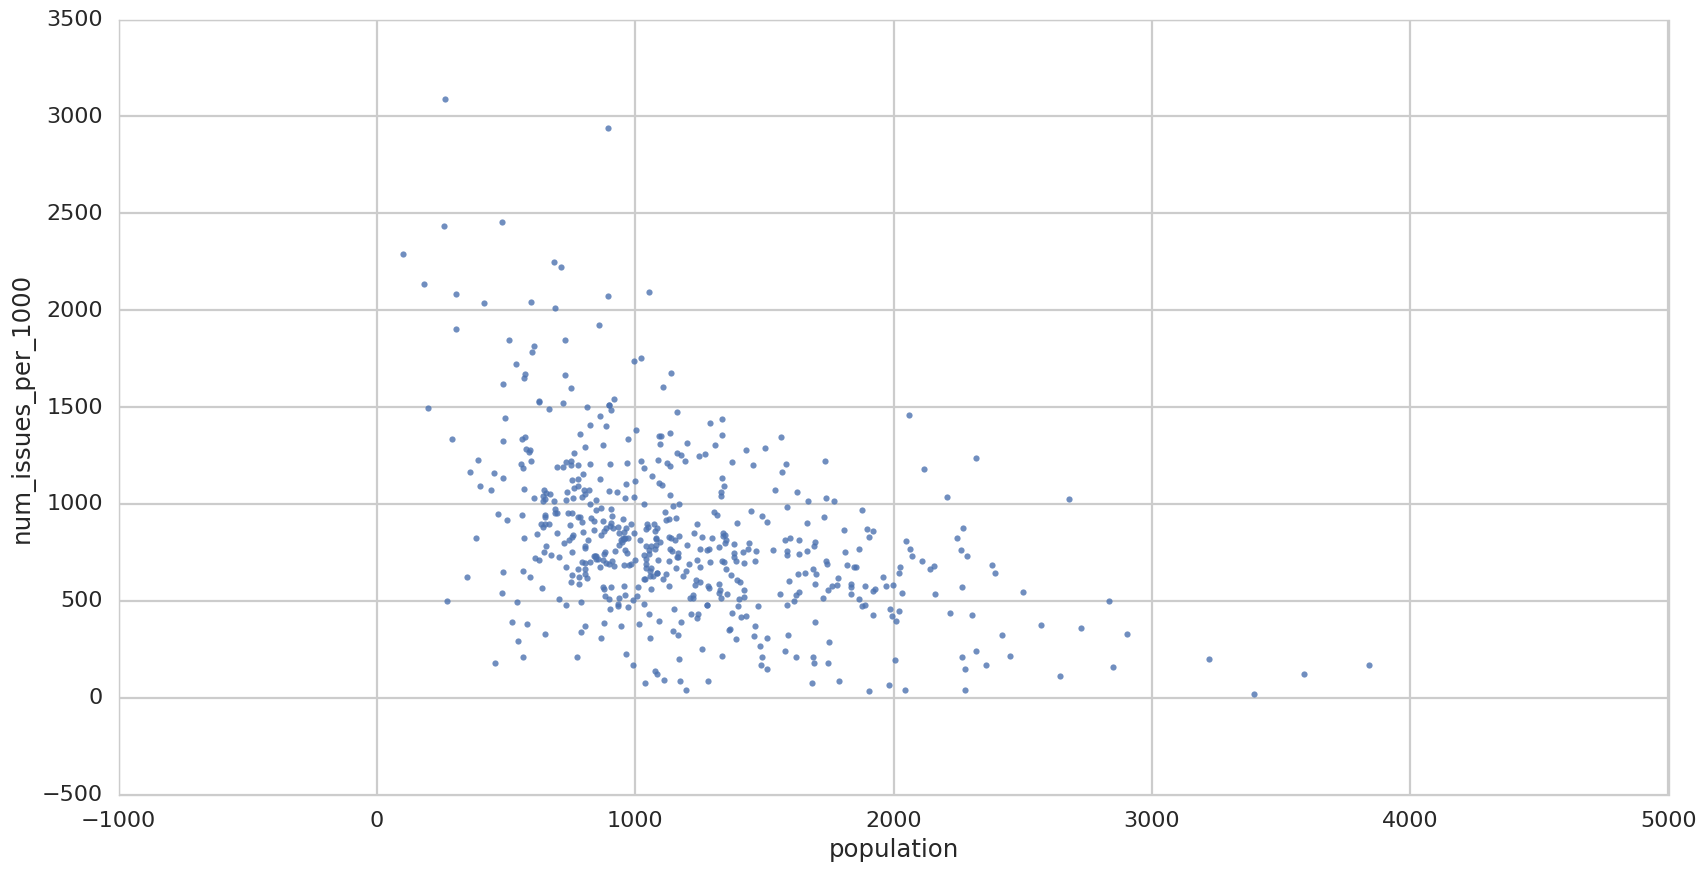

In [10]:
rcParams['figure.figsize'] = 20,10
sns.regplot(x='population', y='num_issues_per_1000', data=df, fit_reg=False);

In [11]:
import plotly
plotly.tools.set_credentials_file(username='aok1425', api_key='AXdoWkmzPvZ3wlUxm0C0')

In [15]:
df[df.num_issues_per_1000 > 2000]

,population,num_issues,num_issues_per_1000,keep
0102034,265.0,819.0,3090.566038,True
0107013,689.0,1387.0,2013.062409,True
0107021,894.0,2628.0,2939.597315,True
0201011,714.0,1588.0,2224.089636,True
0403005,596.0,1216.0,2040.268456,True
0404012,687.0,1544.0,2247.452693,True
0512001,103.0,236.0,2291.262136,True
0612002,483.0,1186.0,2455.486542,True
0701011,1052.0,2203.0,2094.106464,True
0701012,308.0,641.0,2081.168831,True


In [12]:
df.reset_index().iplot(kind='scatter', mode='markers', text='index', x='population', y='num_issues_per_1000', size=5)

PlotlyRequestError: No Content

The points on the top-left quadrant, and also the bottom-right look like outliers. Specifically, the top-left ones are what I was concerned about: the block groups with low pops so as to inflate the number of issues per 1000.

I could use K-means with k=3 to choose the outliers, but a simple visual cutoff and manual inspection will work too. I want to investigate the points where num_issues_per_1000 > 2000, and to a lesser degree, where population > 2750.

## Manual investigation

For y > 2000:

| id      | residential? | comments                        |
|---------|--------------|---------------------------------|
| 0102034  | FALSE        | fenway                          |
| 0107013  | FALSE        | hynes convention ctr            |
| 107021  | TRUE         | copley                          |
| 201011  | TRUE         | beacon hill                     |
| 404012  | TRUE         | Charlestown; over the bridge    |
| 0512001  | FALSE        | east boston waterfront          |
| 0612002  | FALSE        | tracks west of Andrew           |
| 701011  | TRUE         | South Station-ish               |
| 0701012  | FALSE        | downtown crossing               |
| 703002  | TRUE         | by Chinatown and I-90           |
| 806013  | TRUE         | Dudley                          |
| 1101033 | FALSE        | btwn arboretum and forest hills |
| 9812021 | FALSE        | cruise SB place                 |

For x > 2750:

| id     | residential? | comments                              |
|--------|--------------|---------------------------------------|
| 0005024| FALSE        | BC                                    |
| 0008032| FALSE        | BU western part                       |
| 0103002| FALSE        | Simmons, Fenway                       |
| 0104051| FALSE        | Northeastern                          |
| 0507001| TRUE         | eastie                                |
| 0702003| TRUE         | emerson/chinatown                     |
| 0806011| TRUE         | orange line by mass ave station to NE |

In [ ]:
OUTLIERS_COMMERCIAL_INDUSTRIAL = ['0102034', '0107013', '0512001', '0612002', '0701012', '1101033', '9812021']
OUTLIERS_LOW_POP = ['0005024', '0008032', '0103002', '0104051']

## Conclusion

Since the same 5 blocks groups show up year after year as having higher density than the others, and bc that's bc they're in low-population areas, they're outliers. Let's remove them.